In [5]:
import fastf1 as ff1
from fastf1 import plotting
from fastf1.core import Laps
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
import pandas as pd
from timple.timedelta import strftimedelta

/Users/davidshortland/Library/Python/3.8/lib/python/site-packages/fastf1/core.py:1127: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Dutch Grand Prix - Race [v2.2.9]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '10', '16', '

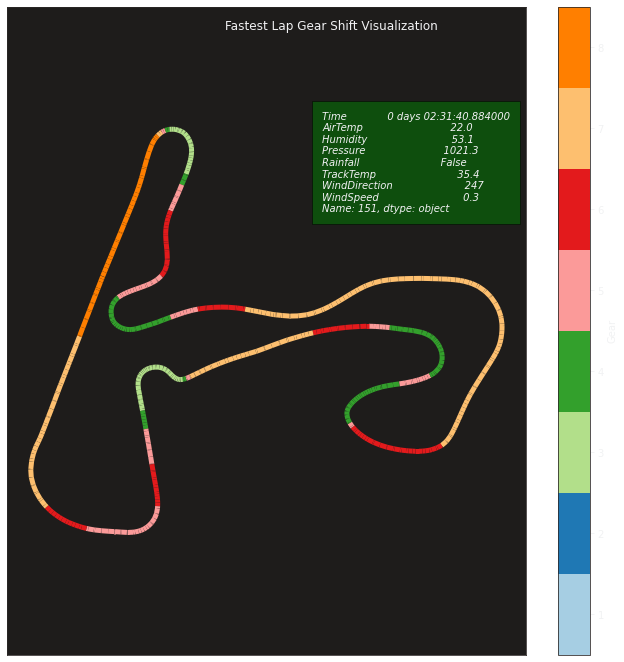

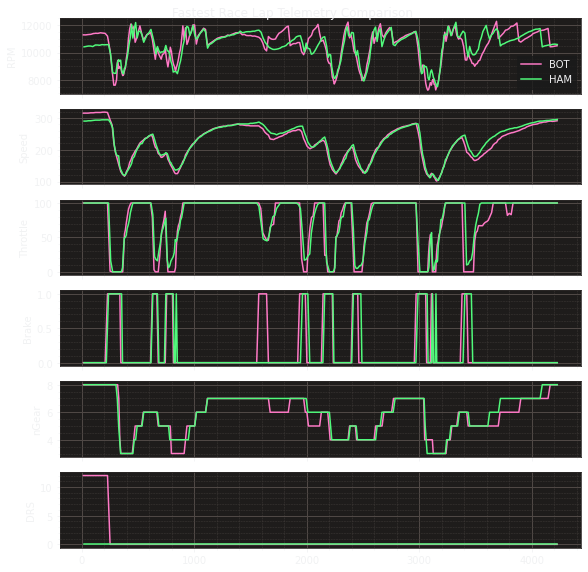

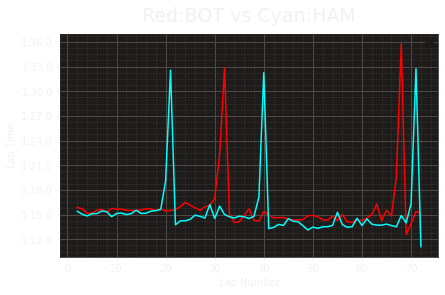

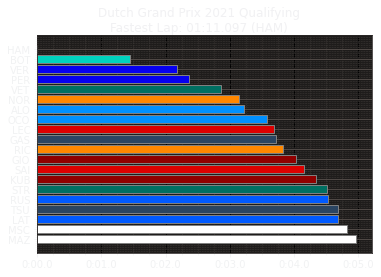

In [6]:
def main():
    plotting.setup_mpl()
    # Picking the laps of the drivers
    laps_driver1 = laps.pick_driver(driver1)
    laps_driver2 = laps.pick_driver(driver2)
    # This is picking the fastest lap of the driver
    fastest_driver1 = laps_driver1.pick_fastest()
    fastest_driver2 = laps_driver2.pick_fastest()
    # Adding the distance from the start of the lap to the current position of the car
    telemetry_driver1 = fastest_driver1.get_car_data().add_distance()
    telemetry_driver2 = fastest_driver2.get_car_data().add_distance()

    def track():  # Track layout - Fastest Lap Gear Shift Visualization
        # A function that is used to plot the fastest lap of the race
        lap = laps.pick_fastest()
        tel = lap.get_telemetry()
        x = np.array(tel['X'].values)
        y = np.array(tel['Y'].values)
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        gear = tel['nGear'].to_numpy().astype(float)
        cmap = plt.get_cmap('Paired')
        lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N + 1), cmap=cmap)
        lc_comp.set_array(gear)
        lc_comp.set_linewidth(5)
        plt.figure(figsize=(9, 9))
        plt.gca().add_collection(lc_comp)
        plt.axis('equal')
        plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
        cbar = plt.colorbar(mappable=lc_comp, label="Gear", boundaries=np.arange(1, 10))
        cbar.set_ticks(np.arange(1.5, 9.5))
        cbar.set_ticklabels(np.arange(1, 9))
        plt.suptitle(f"Fastest Lap Gear Shift Visualization")
        lap = laps.pick_fastest()
        plt.text(5000, 5000, str(lap.get_weather_data()), style='italic', bbox={
            'facecolor': 'green', 'alpha': 0.5, 'pad': 10})
        weather_data = laps.get_weather_data()
        weather_data.reset_index(drop=True)

    def gas(*args):  # Car data
        data = ['RPM', 'Speed', 'Throttle', 'Brake', 'nGear', 'DRS']
        fig, ax = plt.subplots(len(data), figsize=(8, 8))
        fig.suptitle("Fastest Race Lap Telemetry Comparison")
        for i in range(len(data)):
            ax[i].plot(telemetry_driver1['Distance'], telemetry_driver1[data[i]], label=driver1)
            ax[i].plot(telemetry_driver2['Distance'], telemetry_driver2[data[i]], label=driver2)
            ax[i].set(ylabel=data[i])
        for a in ax.flat:
            a.label_outer()
        ax[0].legend()
        fig.subplots_adjust(left=0.095, bottom=0.04, right=1, top=0.96, wspace=None, hspace=None)

    def compare(*args):
        fig, ax = plt.subplots()  # Draw plots
        ax.plot(laps_driver1['LapNumber'], laps_driver1['LapTime'], color='red')
        ax.plot(laps_driver2['LapNumber'], laps_driver2['LapTime'], color='cyan')
        ax.set_title(f"Red:{driver1} vs Cyan:{driver2}")
        ax.set_xlabel("Lap Number")
        ax.set_ylabel("Lap Time")
        plt.legend()
        fig.subplots_adjust(right=1, top=0.9)

    def qualifying():  # Fastest lap

        ff1.plotting.setup_mpl(mpl_timedelta_support=True, color_scheme=None, misc_mpl_mods=False)
        drivers = pd.unique(laps['Driver'])
        list_fastest_laps = list()
        for drv in drivers:
            drvs_fastest_lap = laps.pick_driver(drv).pick_fastest()
            list_fastest_laps.append(drvs_fastest_lap)
        fastest_laps = Laps(list_fastest_laps).sort_values(by='LapTime').reset_index(drop=True)
        pole_lap = fastest_laps.pick_fastest()
        fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime']
        team_colors = list()
        for index, lap in fastest_laps.iterlaps():
            color = ff1.plotting.team_color(lap['Team'])
            team_colors.append(color)
        fig, ax = plt.subplots()
        ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'],
                color=team_colors, edgecolor='grey')
        ax.set_yticks(fastest_laps.index)
        ax.set_yticklabels(fastest_laps['Driver'])
        ax.invert_yaxis()
        ax.set_axisbelow(True)
        ax.xaxis.grid(True, linestyle='--', color='black', zorder=-1000)
        lap_time_string = strftimedelta(pole_lap['LapTime'], '%m:%s.%ms')
        plt.suptitle(f"{race.weekend.name} {race.weekend.year} Qualifying\n"
                     f"Fastest Lap: {lap_time_string} ({pole_lap['Driver']})")

    track()
    gas()
    compare(laps_driver1, laps_driver2)
    qualifying()
    plt.show()


if __name__ == '__main__':
    driver1 = 'BOT' 
    driver2 = 'HAM' 
    ff1.Cache.enable_cache('cache/') # Replace with your cache directory
    race = ff1.get_session(2021, 'Zandvoort', 'R')
    laps = race.load_laps(with_telemetry=True)
    main()